In [176]:
!pip install xlrd
!pip install prophet

In [177]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

from scipy import stats
from statistics import mode

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

In [178]:
df = pd.read_csv("Microsoft_Stock.csv")
df

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012


#EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB






Open: 0.8265398295326284
High: 0.8282639678470909
Low: 0.8276067707807976
Close: 0.8273771005260597
Volume: 2.3981683115718586


Date: ['4/1/2015 16:00:00' '4/2/2015 16:00:00' '4/6/2015 16:00:00' ...
 '3/29/2021 16:00:00' '3/30/2021 16:00:00' '3/31/2021 16:00:00']




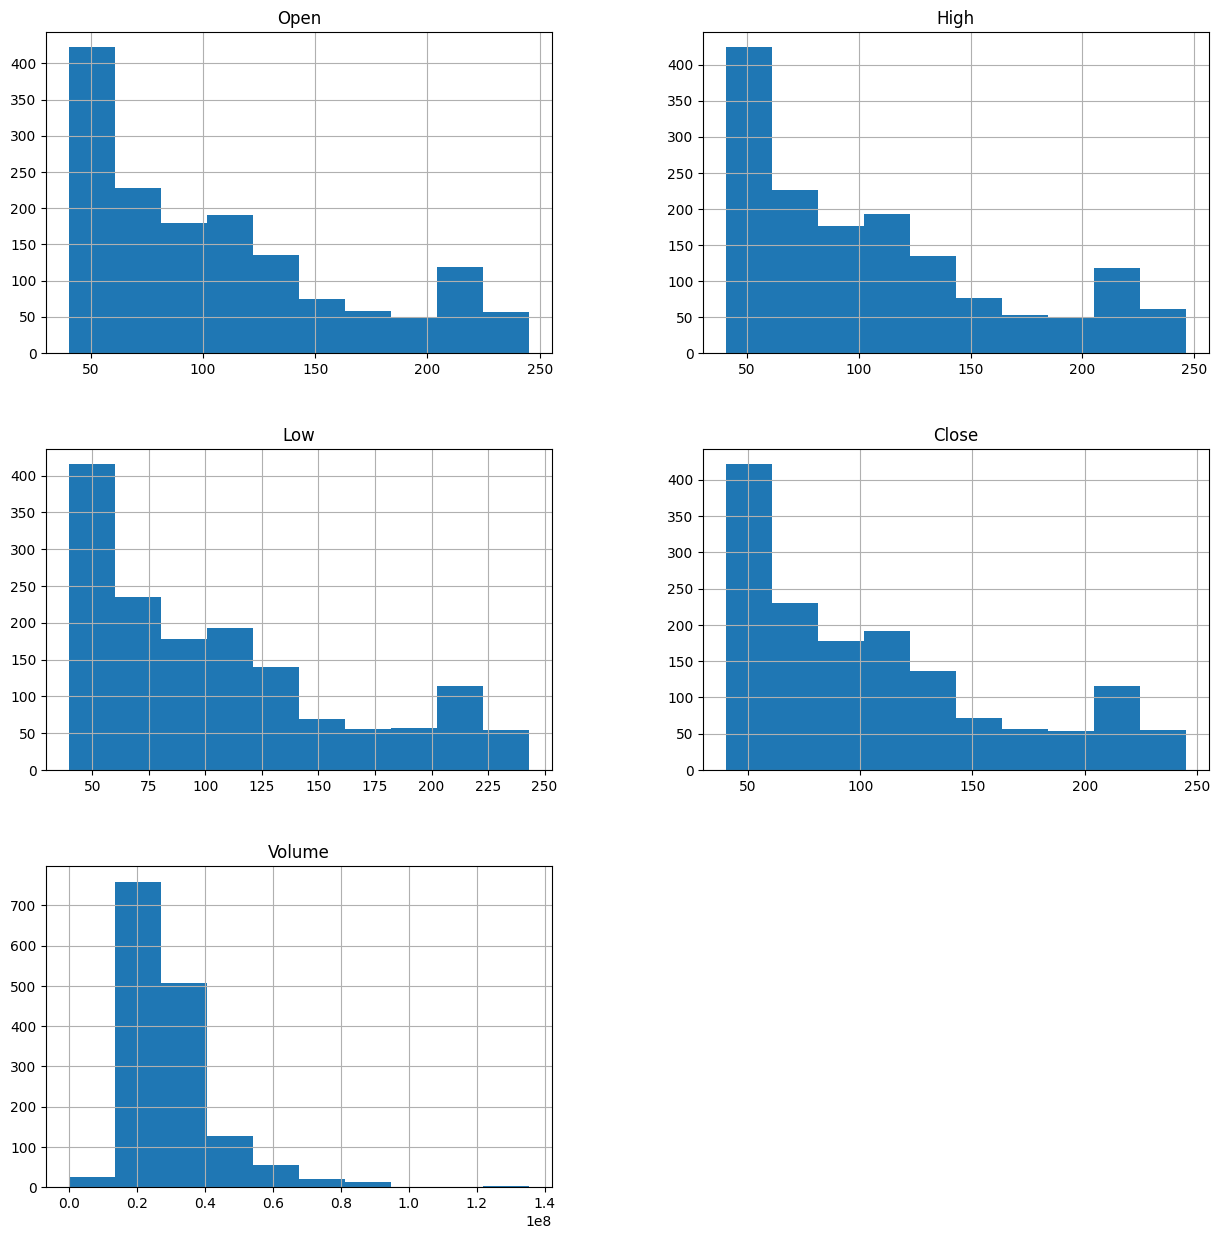

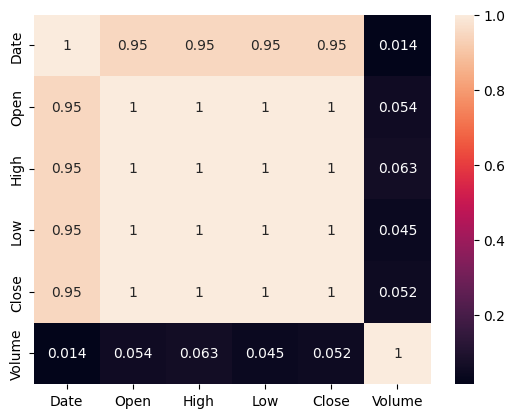

In [179]:
df.info()
print("\n")
df.describe()
print("\n")
df.isnull().sum()
print("\n")
for col in df.select_dtypes(include=np.number):
    print(f'{col}: {df[col].skew()}')
print("\n")
for col in df.select_dtypes(include='object'):
    print(f'{col}: {df[col].unique()}')
print("\n")
df.hist(figsize=(15,15))
plt.show()
print("\n")
df['Date'] = pd.to_datetime(df['Date'])
sns.heatmap(df.corr(), annot=True)
plt.show()
print("\n")


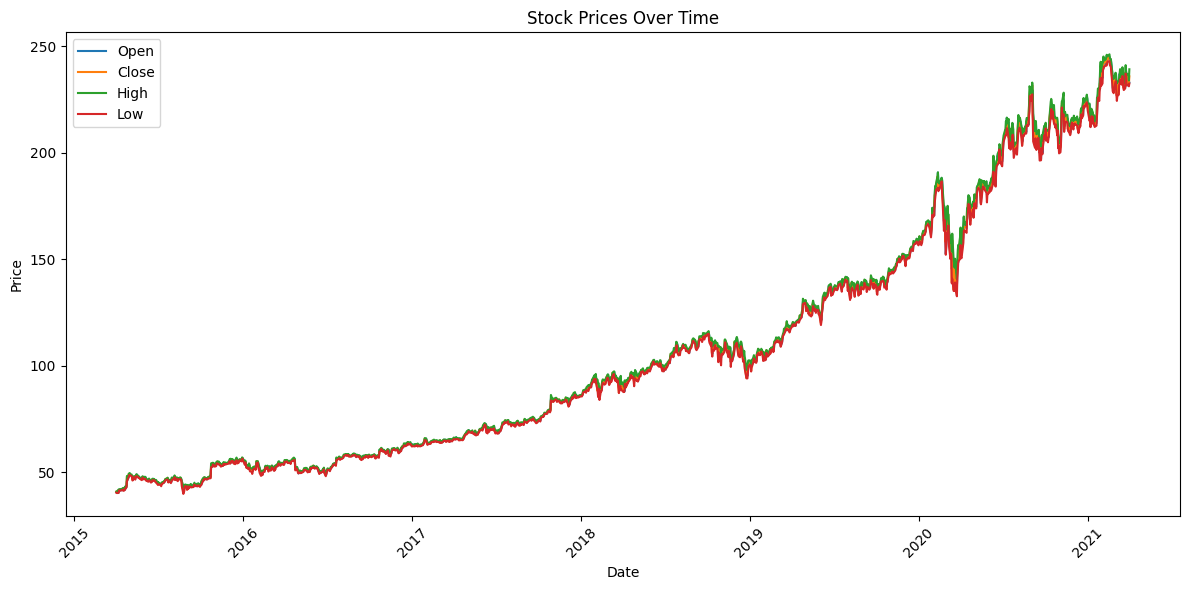

In [180]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Open'], label='Open')
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['High'], label='High')
plt.plot(df['Date'], df['Low'], label='Low')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

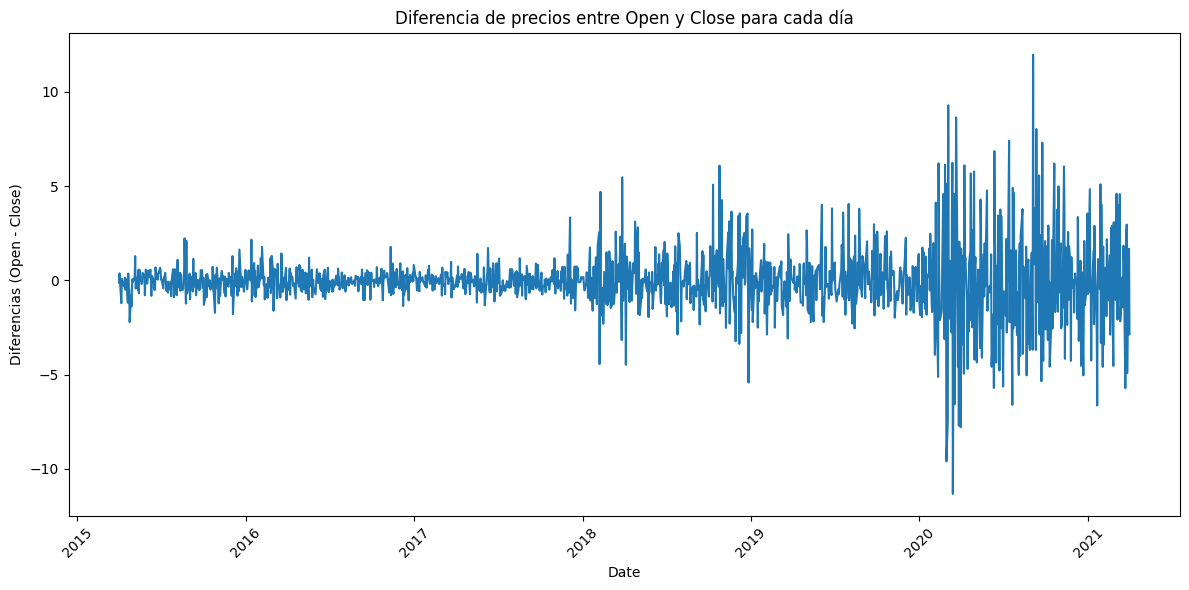

In [181]:
df['Difference'] = df['Open'] - df['Close']

df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Difference'])
plt.xlabel('Date')
plt.ylabel('Diferencias (Open - Close)')
plt.title('Diferencia de precios entre Open y Close para cada día')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

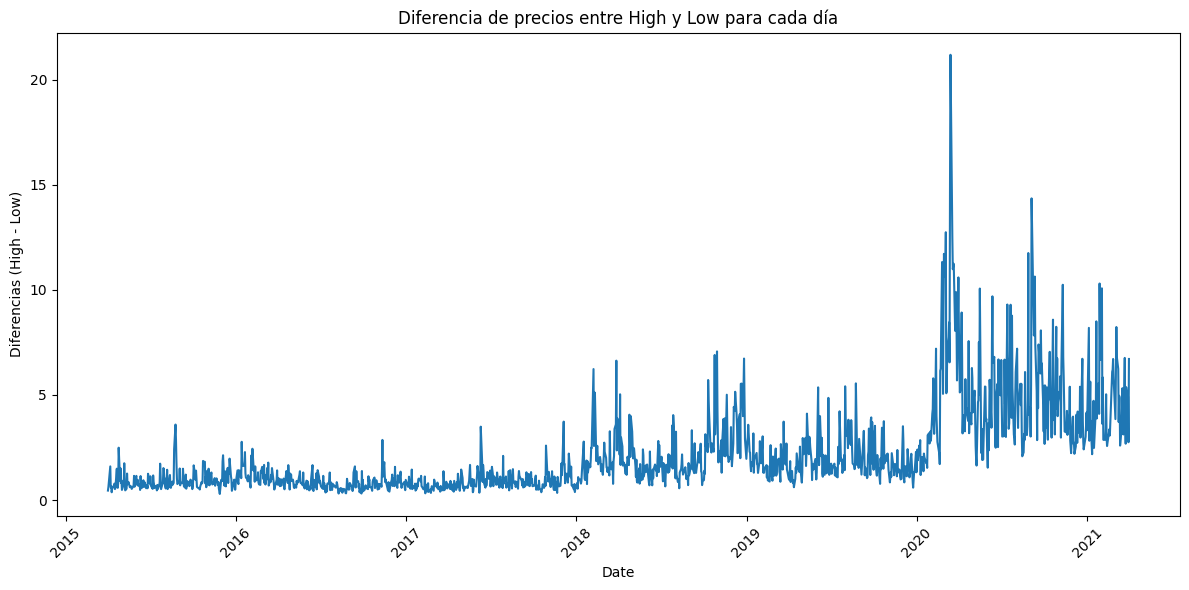

In [182]:

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['High'] - df['Low'])
plt.xlabel('Date')
plt.ylabel('Diferencias (High - Low)')
plt.title('Diferencia de precios entre High y Low para cada día')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Puntos importantes que surgen del EDA:

*   Los histogramas muestran a las variables con alta asimetria positiva.

*   Vemos un movimiento bastante plano del valor de las acciones hasta el 2018, donde toman una tendencia alcista.

*   Ademas, se observa una mayor diferencia entre el precio de apertura y de cierre a partir de este periodo.



#Elaboracion

In [183]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y HH:MM:SS')

data = df.groupby('Date')['Close'].sum().reset_index()
data = data.set_index('Date')
y = data['Close'].resample('MS').mean()

y.fillna(0, inplace=True)

Esto creo que en teoria esta mal. No nos da errores porque no tenemos mas de un registro por fecha, pero si agruparamos y tuviesemos mas de uno, para esa fecha devolveria la suma de las Close, y estaria mal teoricamente.


In [184]:
data

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2021-03-25 16:00:00,232.34
2021-03-26 16:00:00,236.48
2021-03-29 16:00:00,235.24


In [185]:
y

Date
2015-04-01     43.466667
2015-05-01     47.530000
2015-06-01     45.964091
2015-07-01     45.611818
2015-08-01     45.506667
                 ...    
2020-11-01    214.139000
2020-12-01    217.963182
2021-01-01    221.975263
2021-02-01    240.066842
2021-03-01    233.674348
Freq: MS, Name: Close, Length: 72, dtype: float64

<Figure size 1600x1000 with 0 Axes>

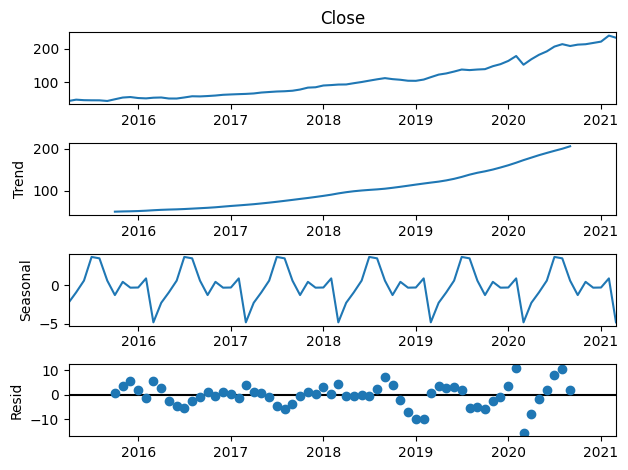

In [186]:
plt.figure(figsize=(16,10))
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()



*   Se observa una tendencia alcista (pareciera lineal)
*   Se observa una "Seasonalidad" tipica de acciones, donde vemos una fuerte alza luego de una caida, como "rebote".
*   A medida que avanza el tiempo, vemos una mayor variabilidad en el grafico de residuos.



CHAT:

*   Si la tendencia muestra un crecimiento o decrecimiento, indica cambios a largo plazo en el valor de las acciones.


*   La estacionalidad ayudará a identificar patrones cíclicos como aumentos en ciertos periodos (por ejemplo, meses específicos).

*   Los residuos deben ser aleatorios y sin patrones visibles si el modelo captura bien la tendencia y la estacionalidad. Si no lo son, podría ser necesario ajustar el modelo o incluir factores adicionales.



In [187]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

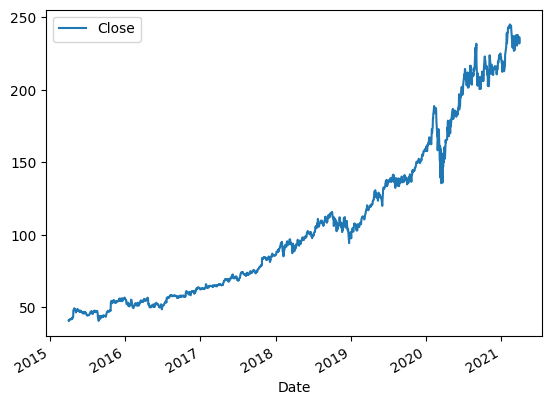

In [188]:
data.plot();

#REESCRIBIR
La serie no es estacionaria. No tiene ni media (tendencia) ni varianza constante (estacionalidad)

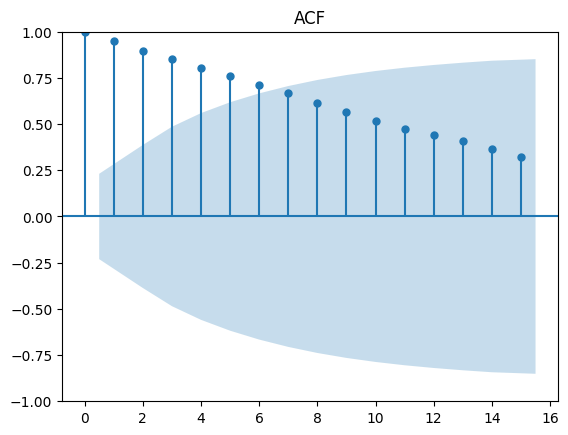

In [189]:
smt.graphics.plot_acf(y, lags=15,title='ACF')
plt.show()

CHAT:

El código genera un **gráfico de autocorrelación (ACF, Autocorrelation Function)**. Este gráfico mide la correlación de la serie de tiempo consigo misma en diferentes retardos (**lags**), hasta un máximo de 15 en este caso.

### Características del gráfico:
1. **Eje x**: Representa los retardos (lags), que son los períodos de tiempo con los que se compara la serie.
2. **Eje y**: Muestra los valores de autocorrelación (que oscilan entre -1 y 1).
3. **Líneas de confianza**: Líneas horizontales alrededor de 0, que representan el intervalo de confianza para la autocorrelación. Si un valor cae fuera de estas líneas, se considera estadísticamente significativo.

### Interpretación:
- **Valores altos y significativos en lag 1**: Indican que los valores actuales están altamente correlacionados con los valores inmediatamente anteriores. Esto sugiere persistencia o dependencia temporal.
- **Patrones decrecientes o ciclos periódicos**: Si la autocorrelación disminuye lentamente o muestra un patrón ondulante, puede reflejar la presencia de tendencia o estacionalidad en los datos.
- **Rápido decaimiento a cero**: Indica que los datos son menos dependientes entre sí en retardos más largos, lo cual puede implicar un comportamiento más aleatorio.
- **Valores significativos en múltiples retardos**: Podrían indicar estacionalidad, especialmente si se repiten en intervalos regulares.

Este gráfico es fundamental para identificar dependencias temporales en los datos y decidir si se necesita un modelo ARIMA o un ajuste adicional a los datos.

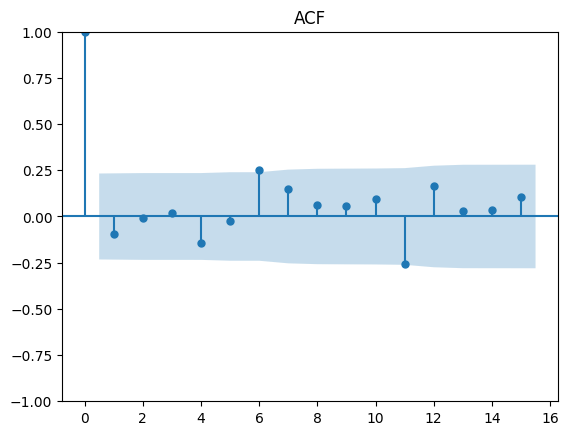

In [190]:
smt.graphics.plot_acf(y.diff()[1:], lags=15,title='ACF')
plt.show()

CHAT:
El código genera un **gráfico de autocorrelación (ACF)**, pero aplicado a la primera diferencia de la serie de tiempo, eliminando el primer valor (ya que al diferenciarlo, se pierde el primer dato). La primera diferencia se calcula como \( y_t - y_{t-1} \), lo que elimina cualquier tendencia a largo plazo, dejando una serie más estacionaria.

### Características del gráfico:
1. **Eje x**: Representa los retardos (**lags**) hasta un máximo de 15.
2. **Eje y**: Muestra los valores de autocorrelación de la serie diferenciada.
3. **Líneas de confianza**: Líneas horizontales alrededor de 0, que marcan el intervalo de confianza. Valores fuera de estas líneas son estadísticamente significativos.

### Interpretación:
Al analizar la serie diferenciada, los patrones cambian porque:
1. **Tendencia eliminada**: La diferenciación remueve cualquier tendencia lineal en los datos, de modo que el gráfico refleja mejor las dependencias temporales puras.
2. **Estacionariedad**: Si la serie era no estacionaria originalmente, la diferenciación la transforma en una serie estacionaria. El ACF ahora mide correlaciones en esta serie transformada.

### Posibles observaciones:
- **Picos significativos solo en los primeros retardos**: Esto indica que el modelo podría necesitar solo un pequeño ajuste, como un componente AR(1).
- **Ausencia de correlaciones significativas**: Esto sugiere que la serie diferenciada es prácticamente ruido blanco, sin dependencias temporales importantes.
- **Ciclos en retardos específicos**: Podrían reflejar estacionalidad en los datos incluso después de la diferenciación.

### Usos:
Este gráfico ayuda a determinar el orden \( q \) en un modelo ARIMA (componente MA, Moving Average), proporcionando información clave para la modelización de series estacionarias.

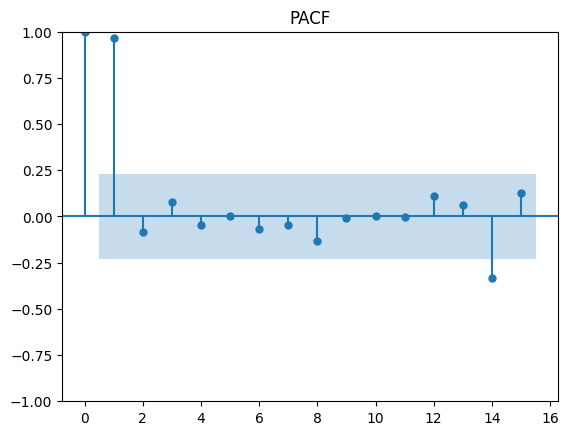

In [191]:
smt.graphics.plot_pacf(y, lags=15,title='PACF')
plt.show();

No hay correlación significativa entre los lags

CHAT:
El código genera un **gráfico de autocorrelación parcial (PACF, Partial Autocorrelation Function)**, que mide la correlación de la serie de tiempo con sus propios valores retrasados (**lags**), eliminando la influencia de los valores intermedios.

### Características del gráfico:
1. **Eje x**: Representa los retardos (**lags**) hasta un máximo de 15.
2. **Eje y**: Muestra los valores de autocorrelación parcial, que oscilan entre -1 y 1.
3. **Líneas de confianza**: Líneas horizontales alrededor de 0, que representan el intervalo de confianza. Si un valor cae fuera de estas líneas, se considera estadísticamente significativo.

### Diferencia entre ACF y PACF:
- El ACF mide la autocorrelación completa (incluyendo efectos indirectos).
- El PACF mide la correlación "directa", eliminando la influencia de los retardos anteriores.

### Interpretación:
- **Lag significativo en el primer retardo (lag 1)**: Suele indicar que un modelo AR(1) (Autoregresivo de orden 1) podría ser adecuado, ya que la relación directa está en el retardo inmediato.
- **Significancia en múltiples retardos consecutivos**: Puede sugerir que un modelo AR de mayor orden (por ejemplo, AR(2), AR(3), etc.) es necesario.
- **Valores significativos en retardos específicos**: Podrían reflejar dependencias específicas a ciertos períodos de tiempo o estacionalidad.

### Posibles observaciones:
1. **Valores significativos solo en lag 1 o 2**: Un modelo AR sencillo podría ser suficiente.
2. **Corte abrupto después de ciertos retardos**: Indica que la dependencia directa con los valores anteriores no se extiende más allá de esos retardos.
3. **Patrones ondulantes o prolongados**: Podrían sugerir un modelo más complejo o la necesidad de ajustar estacionalidad.

### Usos:
El PACF es especialmente útil para identificar el orden \( p \) de la parte autoregresiva en un modelo ARIMA. Este gráfico complementa el ACF, ya que juntos ayudan a determinar los componentes óptimos del modelo.

# Test de Dickey-Fuller aumentado (ADF)


In [192]:
result = adfuller(y);
print('ADF Statistic: %f' % result[0]); print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: 3.832784
p-value: 1.000000
Valor crítico 1%: -3.53
Valor crítico 5%: -2.91
Valor crítico 10%: -2.59


CHAT:
### Interpretación de los resultados del test de Dickey-Fuller aumentado:

1. **Estadístico ADF**:  
   El valor **3.832784** es positivo y mayor que todos los valores críticos (-3.53, -2.91, -2.59), lo que indica que la serie tiene una raíz unitaria y no es estacionaria. Esto significa que no se detecta suficiente evidencia para rechazar la hipótesis nula.

2. **Valor p**:  
   El valor **1.000000** es extremadamente alto (mucho mayor que un nivel de significancia típico como 0.05 o 0.01). Esto refuerza la conclusión de que no se puede rechazar la hipótesis nula.

3. **Valores críticos**:  
   Los valores críticos se usan para comparar el estadístico ADF. Como el estadístico ADF (**3.832784**) no es menor que ninguno de ellos, tampoco se cumple el criterio para rechazar la hipótesis nula.

---

### Conclusión:  
La serie **no es estacionaria**, ya que:
- No se rechaza la hipótesis nula (\(H_0\): la serie tiene una raíz unitaria).
- Esto implica que la serie probablemente tiene tendencia, variabilidad no constante, o alguna estructura temporal que necesita ser ajustada.

---

### Siguiente paso:  
1. **Transformar la serie**:
   - Aplicar una diferenciación (primera o incluso segunda diferencia) para remover tendencias.
   - Revisar si la serie transformada se vuelve estacionaria utilizando nuevamente el test ADF.

2. **Explorar otras transformaciones**:
   - Si la serie tiene estacionalidad, podrías aplicar una diferenciación estacional.
   - Si tiene heterocedasticidad (varianza no constante), podrías aplicar transformaciones logarítmicas o Box-Cox.

3. **Visualización adicional**:
   - Graficar la serie y su función de autocorrelación (ACF/PACF) puede dar más pistas sobre qué tipo de transformación aplicar.

#REESCRIBIR
No es significativo, por lo tanto la serie no es estacionaria (parece sugerir que es estacionario, pero no entiendo nada jajaja)

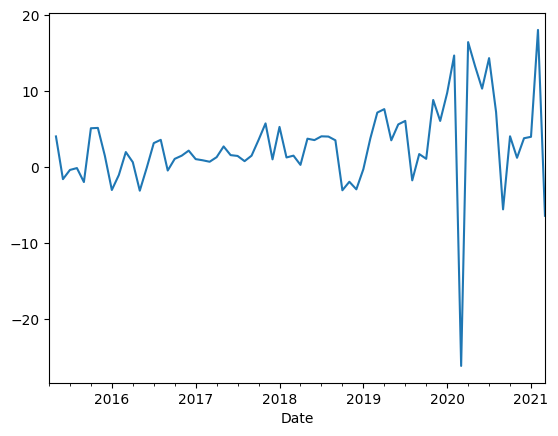

In [193]:
y.diff().plot();

In [194]:
result = adfuller(y.diff()[1:]); print('ADF Statistic: %f' % result[0]);
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))
#El p-valor es = 0, por lo tanto, la serie se convirtió en estacionaria!

ADF Statistic: -8.965316
p-value: 0.000000
Valor crítico 1%: -3.53
Valor crítico 5%: -2.90
Valor crítico 10%: -2.59


#REESCRIBIR
Cuando diferenciamos, la serie se vuelve no estacionaria :) (aca sigue pareciendo estacionaria)

# Transformaciones y Baseline

In [195]:
data["timeIndex"] = pd.Series(np.arange(len(data['Close'])), index=data.index)
data["timeIndex_sq"] = data["timeIndex"]**2

In [196]:
df_train, df_test = train_test_split(data, test_size=0.3, random_state=42, shuffle=False)

In [197]:
df_train

,Close,timeIndex,timeIndex_sq
Date,,,
2015-04-01 16:00:00,40.72,0,0
2015-04-02 16:00:00,40.29,1,1
2015-04-06 16:00:00,41.55,2,4
2015-04-07 16:00:00,41.53,3,9
2015-04-08 16:00:00,41.42,4,16
...,...,...,...
2019-06-06 16:00:00,127.82,1052,1106704
2019-06-07 16:00:00,131.40,1053,1108809
2019-06-10 16:00:00,132.60,1054,1110916


In [198]:
df_test

,Close,timeIndex,timeIndex_sq
Date,,,
2019-06-13 16:00:00,132.32,1057,1117249
2019-06-14 16:00:00,132.45,1058,1119364
2019-06-17 16:00:00,132.85,1059,1121481
2019-06-18 16:00:00,135.16,1060,1123600
2019-06-19 16:00:00,135.69,1061,1125721
...,...,...,...
2021-03-25 16:00:00,232.34,1506,2268036
2021-03-26 16:00:00,236.48,1507,2271049
2021-03-29 16:00:00,235.24,1508,2274064


In [199]:
model_quadratic = smf.ols('Close ~ timeIndex + timeIndex_sq', data = df_train).fit() # Tendencia cuadrática

df_train["QuadraticTrend"] = model_quadratic.predict(df_train[["timeIndex","timeIndex_sq"]])
df_test["QuadraticTrend"] = model_quadratic.predict(df_test[["timeIndex","timeIndex_sq"]])

In [200]:
df_train['log_Close'] = np.log(df_train['Close'])
df_test['log_Close'] = np.log(df_test['Close'])

model_log = smf.ols('log_Close ~ timeIndex ', data = df_train).fit() # Valor Log


df_train["LogTrend"] = model_log.predict(df_train[["timeIndex"]])
df_test["LogTrend"] = model_log.predict(df_test[["timeIndex"]])

df_train['back_LogTrend'] = np.exp(df_train['LogTrend'])
df_test['back_LogTrend'] = np.exp(df_test['LogTrend'])

In [201]:
# Creamos columna con el mes
df_train['month'] = [d.strftime('%b') for d in df_train.index]
df_test['month']  = [d.strftime('%b') for d in df_test.index]

# Creamos las variables dummies de mes
dummies_mes_train = pd.get_dummies(df_train['month'])
dummies_mes_test = pd.get_dummies(df_test['month'])

# Hacemos el join entre el DataFrame con la serie de tiempo y las dummies
df_train = df_train.join(dummies_mes_train)
df_test = df_test.join(dummies_mes_test)

#Por defecto ordena las dummies alfabéticamente

In [202]:
model_log_est = smf.ols('log_Close ~ timeIndex + Apr + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = df_train).fit()

df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex","Apr","Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]])

df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex","Apr","Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]])

df_train['back_LogEstTrend'] = np.exp(df_train['model_log_est'])
df_test['back_LogEstTrend'] = np.exp(df_test['model_log_est'])

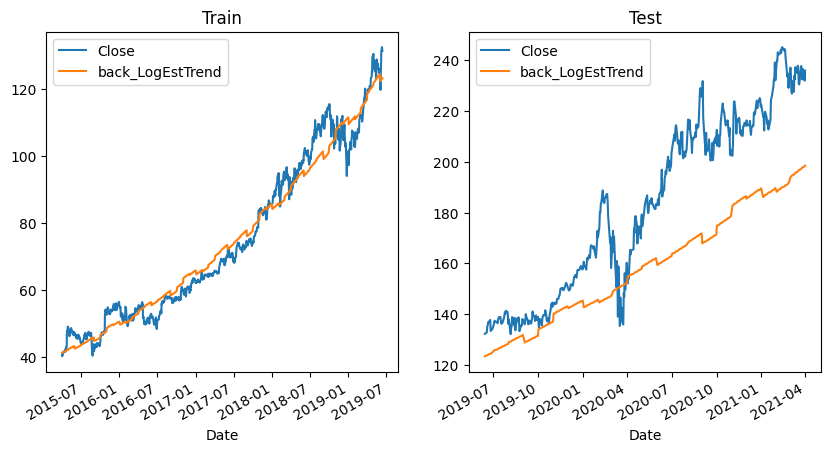

In [203]:
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df_train.plot(kind = "line", y = ["Close","back_LogEstTrend"],ax=axes[0],title='Train');
df_test.plot(kind = "line", y = ["Close","back_LogEstTrend"],ax=axes[1],title='Test');
plt.show()

In [204]:
RMSE(df_test.back_LogEstTrend, df_test.Close)

28.4204811490095

# ARIMA

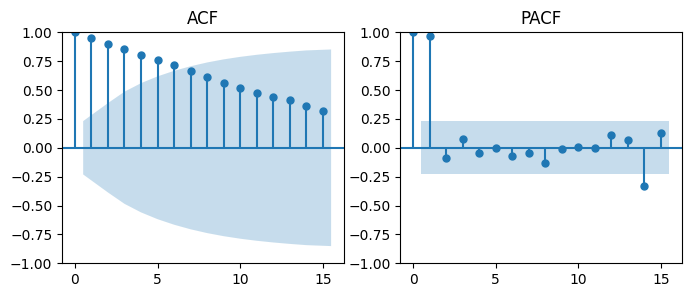

In [205]:
fig, axes = plt.subplots(1, 2,figsize=(8,3))
smt.graphics.plot_acf(y, lags=15,ax=axes[0],title='ACF')
smt.graphics.plot_pacf(y, lags=15,ax=axes[1],title='PACF')
plt.show()

Para el modelo ARIMA:


1.   p = 1 (lags significativos de PACF)
2.   d = 1 (por ser estacionaria)
3.   q = 6 (lags significativos de ACF)




In [206]:
model_ARIMA = ARIMA(y, order=(1,1,6))
results_ARIMA = model_ARIMA.fit()

In [207]:
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   72
Model:                 ARIMA(1, 1, 6)   Log Likelihood                -221.381
Date:                Tue, 26 Nov 2024   AIC                            458.762
Time:                        18:42:36   BIC                            476.863
Sample:                    04-01-2015   HQIC                           465.960
                         - 03-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9093      0.069     13.172      0.000       0.774       1.045
ma.L1         -1.1304      0.340     -3.320      0.001      -1.798      -0.463
ma.L2          0.2214      0.201      1.101      0.2

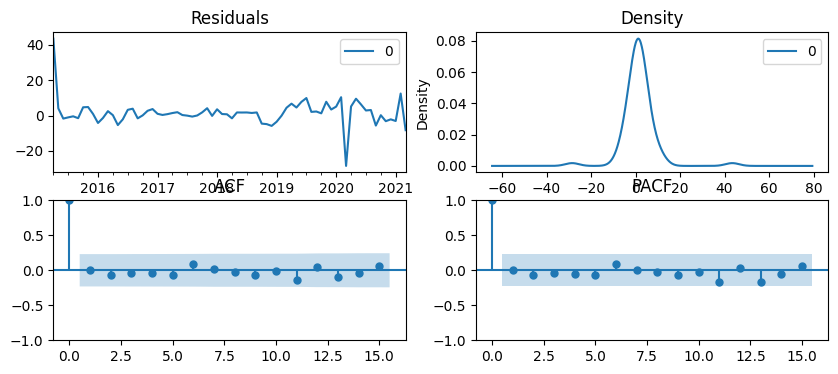

In [208]:
residuals = pd.DataFrame(results_ARIMA.resid)
fig, axes = plt.subplots(2, 2,figsize=(10,4))

residuals.plot(title="Residuals", ax=axes[0,0]);
residuals.plot(kind='kde', title='Density', ax=axes[0,1])
smt.graphics.plot_acf(residuals, lags=15,ax=axes[1,0],title='ACF');
smt.graphics.plot_pacf(residuals, lags=15,ax=axes[1,1],title='PACF')
plt.show()

El error es ruido blanco y ya no hay autocorrelación

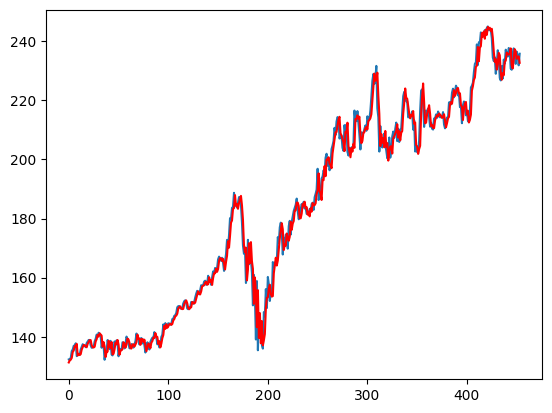

In [209]:
X = data['Close']
arima_train, arima_test = train_test_split(X, test_size=0.3, random_state=42, shuffle=False)

history = arima_train.copy().values
predictions_arima = list()

for t in range(len(arima_test)):
    model = ARIMA(history, order=(1,1,6))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)

    obs = arima_test[t]
    history = np.append(history, obs) # agrega el registro de test al set de entrenamiento para el forecast del siguiente período

plt.plot(arima_test.values)
plt.plot(predictions_arima, color='red')
plt.show()

In [210]:
rmse = sqrt(mean_squared_error(arima_test.values, predictions_arima))
print(f'RMSE: {rmse:.2f}')

RMSE: 3.81


El modelo predice un período de test y, antes de predecir el

---

siguiente, entrena con el valor real del período anterior. Este es una práctica común y recomendable al trabajar con ARIMA. Parece que overfittea pero no hay indicativos de que así sea...

# PROPHET

In [211]:
prophet_train, prophet_test = train_test_split(data, test_size=0.3, random_state=42, shuffle=False)

In [212]:
prophet_train = prophet_train.reset_index().rename(columns={'Date':'ds','Close':'y'},inplace=False)
prophet_test = prophet_test.reset_index().rename(columns={'Date':'ds','Close':'y'},inplace=False)

prophet_train['ds'] = pd.to_datetime(prophet_train['ds'])
prophet_test['ds'] = pd.to_datetime(prophet_test['ds'])

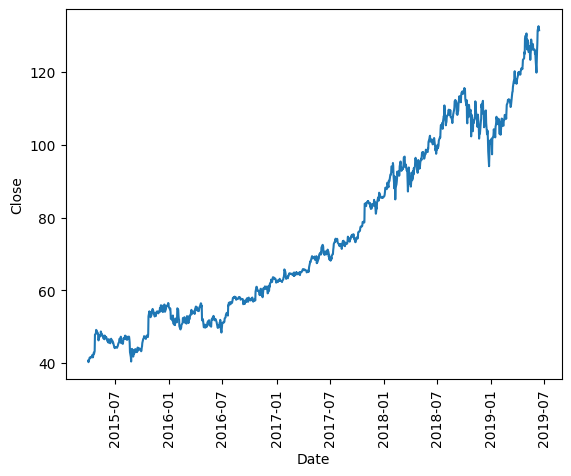

In [213]:
# Visualize the data
plt.plot(prophet_train['ds'], prophet_train['y'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=90)
plt.show()

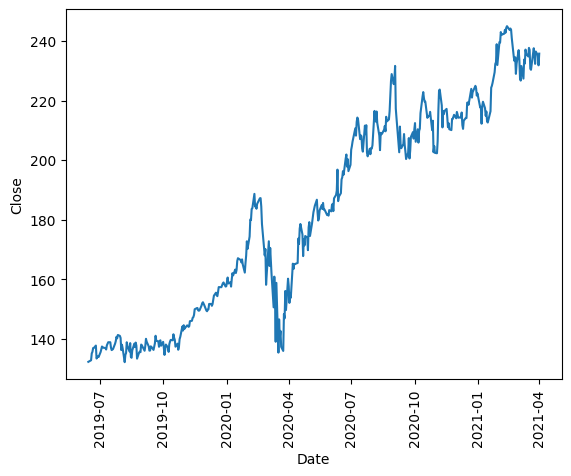

In [214]:
# Visualize the data
plt.plot(prophet_test['ds'], prophet_test['y'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=90)
plt.show()

In [215]:
# Create a Prophet object and fit it to the data
model = Prophet()
model.fit(prophet_train)

18:46:35 - cmdstanpy - INFO - Chain [1] start processing
18:46:35 - cmdstanpy - INFO - Chain [1] done processing


In [216]:
# Make predictions for the future dates

predictions_prophet = model.predict(prophet_test)
predictions_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
449,2021-03-25 16:00:00,172.273182,49.391465,307.055971
450,2021-03-26 16:00:00,172.472201,50.640072,305.609100
451,2021-03-29 16:00:00,172.693317,49.399725,304.804367
452,2021-03-30 16:00:00,172.901798,49.506104,306.708267
453,2021-03-31 16:00:00,172.990122,49.149428,307.679528


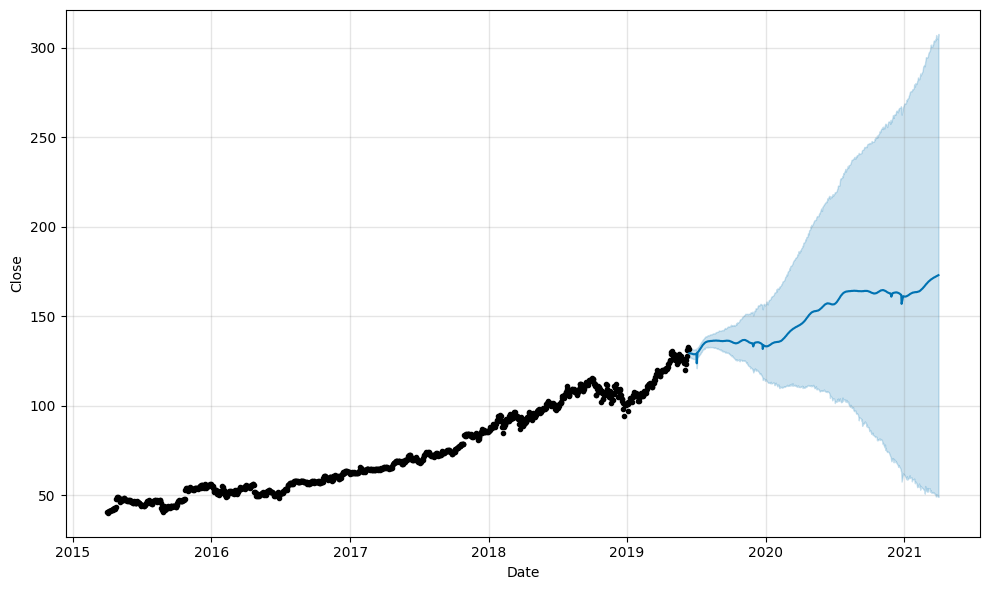

In [217]:
# Visualize the predictions
model.plot(predictions_prophet)
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

In [218]:
predictions_prophet

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-13 16:00:00,111.270159,126.706488,132.220698,111.270159,111.270159,18.111518,18.111518,18.111518,-10.925214,...,24.784377,24.784377,24.784377,4.252355,4.252355,4.252355,0.0,0.0,0.0,129.381677
1,2019-06-14 16:00:00,111.346331,127.077880,132.067127,111.346331,111.346331,18.121647,18.121647,18.121647,-10.925214,...,24.870524,24.870524,24.870524,4.176337,4.176337,4.176337,0.0,0.0,0.0,129.467978
2,2019-06-17 16:00:00,111.574846,127.045105,131.755832,111.574846,111.574846,17.663093,17.663093,17.663093,-10.925214,...,24.744433,24.744433,24.744433,3.843874,3.843874,3.843874,0.0,0.0,0.0,129.237939
3,2019-06-18 16:00:00,111.651018,126.629161,131.689570,111.651018,111.651018,17.613376,17.613376,17.613376,-10.925214,...,24.831500,24.831500,24.831500,3.707090,3.707090,3.707090,0.0,0.0,0.0,129.264395
4,2019-06-19 16:00:00,111.727190,126.770733,131.866351,111.727190,111.727190,17.431484,17.431484,17.431484,-10.925214,...,24.794053,24.794053,24.794053,3.562645,3.562645,3.562645,0.0,0.0,0.0,129.158674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,2021-03-25 16:00:00,160.858046,49.391465,307.055971,39.027088,293.986954,11.415136,11.415136,11.415136,-10.925214,...,24.784377,24.784377,24.784377,-2.444027,-2.444027,-2.444027,0.0,0.0,0.0,172.273182
450,2021-03-26 16:00:00,160.934218,50.640072,305.609100,38.733285,294.386143,11.537983,11.537983,11.537983,-10.925214,...,24.870524,24.870524,24.870524,-2.407327,-2.407327,-2.407327,0.0,0.0,0.0,172.472201
451,2021-03-29 16:00:00,161.162733,49.399725,304.804367,38.591824,294.937676,11.530584,11.530584,11.530584,-10.925214,...,24.744433,24.744433,24.744433,-2.288635,-2.288635,-2.288635,0.0,0.0,0.0,172.693317
452,2021-03-30 16:00:00,161.238905,49.506104,306.708267,38.261056,295.196823,11.662893,11.662893,11.662893,-10.925214,...,24.831500,24.831500,24.831500,-2.243393,-2.243393,-2.243393,0.0,0.0,0.0,172.901798


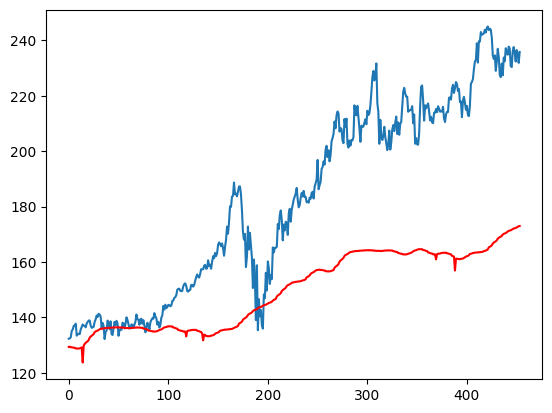

In [219]:
plt.plot(prophet_test['y'].values)
plt.plot(predictions_prophet.yhat, color='red')
plt.show()

In [220]:
rmse = sqrt(mean_squared_error(prophet_test.y, predictions_prophet.yhat))
print(f'RMSE: {round(rmse,2)}')

RMSE: 39.62


# Prophet entrenado por período

18:46:35 - cmdstanpy - INFO - Chain [1] start processing
18:46:36 - cmdstanpy - INFO - Chain [1] done processing
18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:36 - cmdstanpy - INFO - Chain [1] done processing
18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:37 - cmdstanpy - INFO - Chain [1] done processing
18:46:37 - cmdstanpy - INFO - Chain [1] start processing
18:46:37 - cmdstanpy - INFO - Chain [1] done processing
18:46:37 - cmdstanpy - INFO - Chain [1] start processing
18:46:37 - cmdstanpy - INFO - Chain [1] done processing
18:46:37 - cmdstanpy - INFO - Chain [1] start processing
18:46:38 - cmdstanpy - INFO - Chain [1] done processing
18:46:38 - cmdstanpy - INFO - Chain [1] start processing
18:46:38 - cmdstanpy - INFO - Chain [1] done processing
18:46:38 - cmdstanpy - INFO - Chain [1] start processing
18:46:38 - cmdstanpy - INFO - Chain [1] done processing
18:46:38 - cmdstanpy - INFO - Chain [1] start processing
18:46:39 - cmdstanpy - INFO - Chain [1]

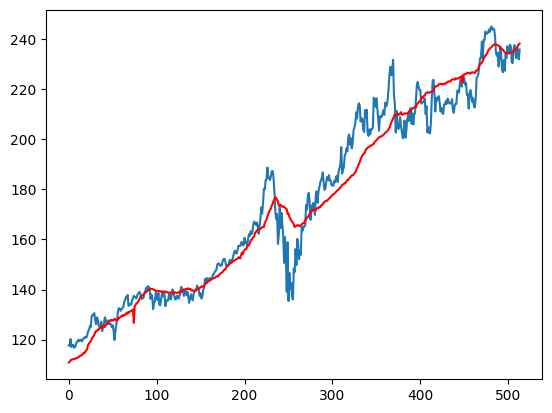

In [221]:
X = data.reset_index().rename(columns={'Date':'ds','Close':'y'})[['ds','y']]

size = int(len(X) * 0.66)
prophet_train = X.iloc[:size]
prophet_test = X.iloc[size:]

history = prophet_train.copy()
predictions_prophet_comp = []

#Nos movemos de a un lag por vez y entrenamos el modelo sucesivas veces, a partir de la historia disponible
for t in range(len(prophet_test)):
  # Ajusta el modelo Prophet con los datos históricos
  model = Prophet()
  model.fit(history)

  # Predice solo el siguiente punto
  future = pd.DataFrame({'ds': [prophet_test.iloc[t]['ds']]})  # Fecha del próximo punto
  forecast = model.predict(future)
  yhat = forecast['yhat'].values[0]

  # Guarda la predicción
  predictions_prophet_comp.append(yhat)

  # Añade el valor real a la historia para el siguiente paso
  obs = prophet_test.iloc[t]
  history = pd.concat([history, obs.to_frame().T], ignore_index=True)


plt.plot(prophet_test['y'].values)
plt.plot(predictions_prophet_comp, color='red')
plt.show()

In [222]:
rmse = sqrt(mean_squared_error(prophet_test['y'], predictions_prophet_comp))
print(f'RMSE: {rmse:.2f}')

RMSE: 8.42


#Deploy

In [223]:
import pandas as pd
import shelve
import pickle
import seaborn as sns
import requests
!pip install flask
from flask import Flask

In [265]:
X = data["Close"]
X = X.copy().values
model = ARIMA(X, order=(1,1,6))
model = model.fit()
with open("./modelo_acciones.pkl", 'wb') as file:
  pickle.dump(model, file)

app = Flask("Modelo Acciones")

@app.route("/", methods=["GET"])
def hello():
  alive = "La app esta viva"
  return alive
@app.route("/predict/<dias>", methods=["GET"])
def predictSales(dias):
  model = None
  with open("./modelo_acciones.pkl", 'rb') as file:
    model = pickle.load(file)
  try:
    dias = int(dias)
  except:
    dias = 1
  #df_dia = pd.DataFrame(data = [dia], columns =  ["Close"])
  output = model.forecast(dias)
  stringDevolver = ""
  i=0
  for result in output:
    i+=1
    stringDevolver +=  "Precio de cierre dia " + str(i) +": US$" +  str(result) + ", "
  return stringDevolver

In [266]:
app.run(host = '0.0.0.0', port = 5017)

 * Serving Flask app 'Modelo Acciones'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5017
 * Running on http://192.168.0.69:5017
Press CTRL+C to quit
127.0.0.1 - - [26/Nov/2024 23:41:58] "GET /predict/15 HTTP/1.1" 200 -
